In [38]:
import torch
import numpy as np
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
from datasets import load_dataset
from sacrebleu import corpus_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm
from sacrebleu.metrics import BLEU

bleu_scorer = BLEU(effective_order=True)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)
model.train()

Running on device: cpu


MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        

In [40]:
dataset = load_dataset("wmt14", "de-en", split="test[:30]")  # 可改大一点

def get_text_pairs(direction="en-de"):
    src, tgt = [], []
    for item in dataset:
        if direction == "en-de":
            src.append(item["translation"]["en"])
            tgt.append(item["translation"]["de"])
        else:
            src.append(item["translation"]["de"])
            tgt.append(item["translation"]["en"])
    return src, tgt

In [41]:
def mc_dropout_translate(model, tokenizer, sentences, src_lang, tgt_lang, num_samples=5):
    model.eval()
    for module in model.modules():
        if module.__class__.__name__.startswith("Dropout"):
            module.train()  # Enable dropout at inference

    all_probs, translations = [], []

    for s in tqdm(sentences, desc=f"Translating {src_lang[:2]}→{tgt_lang[:2]}"):
        tokenizer.src_lang = src_lang
        encoded = tokenizer(s, return_tensors="pt").to(device)
        input_ids = encoded["input_ids"]

        probs_list, outputs_list = [], []
        for _ in range(num_samples):
            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                    max_length=64,
                    num_beams=1,
                    output_scores=True,
                    return_dict_in_generate=True,
                )
            # Compute token-level probabilities
            logits = torch.stack(output.scores, dim=1)
            probs = torch.nn.functional.softmax(logits, dim=-1).mean().item()
            probs_list.append(probs)

            decoded = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
            outputs_list.append(decoded)

        all_probs.append(np.mean(probs_list))
        translations.append(outputs_list[0])

    # sentence-level entropy (optional)
    entropy = -np.mean(np.log(np.clip(all_probs, 1e-10, 1)))
    return translations, all_probs, entropy


In [ ]:
# Compute reliability (ECE)
def compute_reliability(probs, labels, n_bins=5):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers, accuracies, confs = [], [], []
    ece = 0.0
    for i in range(n_bins):
        idx = (probs > bins[i]) & (probs <= bins[i + 1])
        if np.sum(idx) == 0:
            continue
        acc = np.mean(labels[idx])
        conf = np.mean(probs[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(probs)
        bin_centers.append((bins[i] + bins[i + 1]) / 2)
        accuracies.append(acc)
        confs.append(conf)
    return ece, bin_centers, accuracies, confs

# Compute BLEU, probs, labels, ECE, Brier, entropy
def run_direction(direction):
    if direction == "en-de":
        src_lang, tgt_lang = "en_XX", "de_DE"
    else:
        src_lang, tgt_lang = "de_DE", "en_XX"

    src_sentences, tgt_sentences = get_text_pairs(direction)
    translations, probs, entropy = mc_dropout_translate(model, tokenizer, src_sentences, src_lang, tgt_lang)

    # Compute sentence-level BLEU as label threshold
    labels = np.array([1 if bleu_scorer.sentence_score(t, [s]).score / 100 > 0.5 else 0
                       for s, t in zip(tgt_sentences, translations)])
    probs = np.array(probs)

    ece = compute_ece(probs, labels)
    brier = compute_brier(probs, labels)
    bleu = corpus_bleu(translations, [tgt_sentences]).score
    return probs, labels, ece, brier, bleu, entropy

# Compute ECE and reliability data for plotting
def compute_ece(probs, labels):
    _, _, _, _ = compute_reliability(probs, labels)
    bins = np.linspace(0, 1, 11)
    ece = 0.0
    for i in range(len(bins) - 1):
        idx = (probs > bins[i]) & (probs <= bins[i + 1])
        if np.sum(idx) == 0:
            continue
        acc = np.mean(labels[idx])
        conf = np.mean(probs[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(probs)
    return ece

def compute_brier(probs, labels):
    return np.mean((probs - labels) ** 2)

In [43]:
probs_en_de, labels_en_de, ece_en_de, brier_en_de, bleu_en_de, entropy_en_de = run_direction("en-de")
probs_de_en, labels_de_en, ece_de_en, brier_de_en, bleu_de_en, entropy_de_en = run_direction("de-en")

print("\n========== Results ==========")
print(f"EN→DE: BLEU={bleu_en_de:.2f}, ECE={ece_en_de:.4f}, Brier={brier_en_de:.4f}, Entropy={entropy_en_de:.4f}")
print(f"DE→EN: BLEU={bleu_de_en:.2f}, ECE={ece_de_en:.4f}, Brier={brier_de_en:.4f}, Entropy={entropy_de_en:.4f}")
print(f"ΔECE = {ece_en_de - ece_de_en:.4f}")



Translating de→en: 100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


========== Results ==========
EN→DE: BLEU=21.03, ECE=0.7333, Brier=0.7333, Entropy=12.4294
DE→EN: BLEU=23.20, ECE=0.8000, Brier=0.8000, Entropy=12.4294
ΔECE = -0.0667


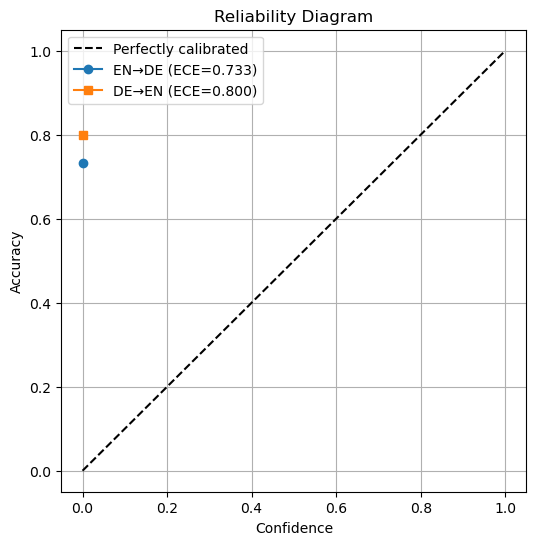

In [44]:
# Compute reliability diagram data
_, bins_en_de, accs_en_de, confs_en_de = compute_reliability(probs_en_de, labels_en_de)
_, bins_de_en, accs_de_en, confs_de_en = compute_reliability(probs_de_en, labels_de_en)

# Plot
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], "k--", label="Perfectly calibrated")
plt.plot(confs_en_de, accs_en_de, "o-", label=f"EN→DE (ECE={ece_en_de:.3f})")
plt.plot(confs_de_en, accs_de_en, "s-", label=f"DE→EN (ECE={ece_de_en:.3f})")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)
plt.show()